In [1]:
import pandas as pd
from textblob import TextBlob
import matplotlib.pyplot as plt
import numpy as np
from transformers import AutoTokenizer, pipeline
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

#### Workflow
- `Sentiment Analysis`: This would involve using natural language processing (NLP) techniques to analyze the language used in the reviews and classify them as positive, negative or neutral.
    - TextBlob: TextBlob is a Python library that provides a simple API for performing sentiment analysis. It uses a pre-trained sentiment analysis model to classify text as positive, negative, or neutral.

    - VaderSentiment: VaderSentiment is a Python library that provides a pre-trained sentiment analysis model specifically designed for analyzing social media text. It uses a lexicon-based approach to analyze the sentiment of text data and provides scores for positivity, negativity, and neutrality.

    - Hugging Face Transformers: Hugging Face Transformers is a Python library that provides a wide range of pre-trained natural language processing models, including models for sentiment analysis.

    - spaCy: spaCy is a Python library that provides a wide range of natural language processing tools, including a pre-trained sentiment analysis model.

- `Frequency analysis` involves analyzing the frequency of individual words or phrases in a given text or corpus. This can be useful for identifying common themes or topics in the text, as well as for identifying commonly used words or phrases. For example, in a collection of customer reviews for a product, frequency analysis could be used to identify the most commonly mentioned features or the most commonly used words to describe the product.
    
- `Topic Modeling`: Another important aspect of analyzing reviews would be to identify the main topics or themes that customers are discussing. This would involve using topic modeling techniques such as Latent Dirichlet Allocation (LDA) to identify the main topics that customers are discussing and the frequency of these topics.

- `Visualization`

### Sentiment Analysis

#### TextBlob

In [2]:
#load data
df = pd.read_csv("data/clean_all_reviews.csv")
df.head()

,reviews
0,worst experience life trying deal customer ser...
1,due code sharing cathay pacific downgraded ba ...
2,lhr check quick first wing quickly security. f...
3,recommend british airways all. tried call cust...
4,absolutely horrible experience. booked ticket ...


In [3]:
# Define a function to calculate the sentiment polarity of a text using TextBlob
def get_sentiment(text):
    blob = TextBlob(text)
    polarity = blob.sentiment.polarity
    if polarity > 0:
        return 'positive'
    elif polarity < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply the function to the all_reviews column of the DataFrame to calculate the sentiment polarity of each review
df['polarity'] = df['reviews'].apply(get_sentiment)

# Print the DataFrame to see the results
df.head()

,reviews,polarity
0,worst experience life trying deal customer ser...,negative
1,due code sharing cathay pacific downgraded ba ...,negative
2,lhr check quick first wing quickly security. f...,positive
3,recommend british airways all. tried call cust...,negative
4,absolutely horrible experience. booked ticket ...,negative


In [4]:
def plot_polarity(col):
    # Count the occurrences of each sentiment
    sentiment_counts = df[col].value_counts()
    print(sentiment_counts)
    fig, ax = plt.subplots()
    ax.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
    ax.set_title('Sentiment Distribution')
    plt.show()

polarity
positive    2512
negative     978
neutral       19
Name: count, dtype: int64


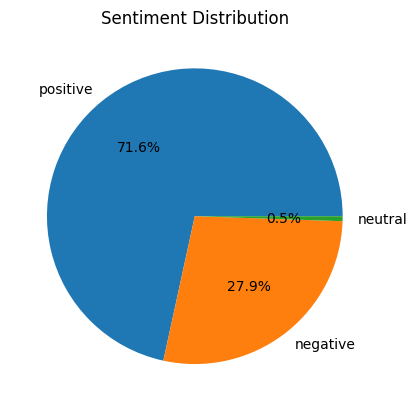

In [5]:
plot_polarity('polarity')

#### Hugging Face Transformer

In [6]:
df.head()

,reviews,polarity
0,worst experience life trying deal customer ser...,negative
1,due code sharing cathay pacific downgraded ba ...,negative
2,lhr check quick first wing quickly security. f...,positive
3,recommend british airways all. tried call cust...,negative
4,absolutely horrible experience. booked ticket ...,negative


In [7]:
def hugging_face(model, col):    
    # Define the sentiment analysis pipeline
    classifier = pipeline("sentiment-analysis", max_length=500, truncation=True, model=model)

    # Define a function to classify the sentiment of a single text
    def get_sentiment(text):
        result = classifier(text)
        return result[0]['label']

    # Apply the function to the all_reviews column of the DataFrame to classify the sentiment of each review
    df[col] = df['reviews'].apply(get_sentiment)

    # Print the DataFrame to see the results
    df.head()

In [8]:
hugging_face('distilbert-base-uncased-finetuned-sst-2-english', 'hugging-sentiment')

hugging-sentiment
NEGATIVE    2507
POSITIVE    1002
Name: count, dtype: int64


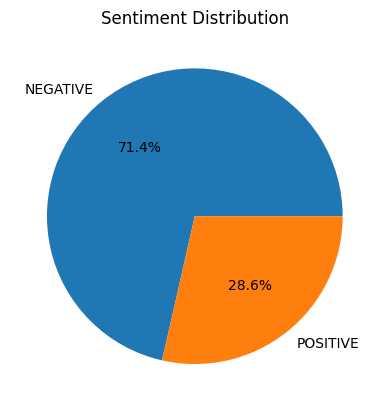

In [9]:
plot_polarity('hugging-sentiment')

In [10]:
hugging_face('nlptown/bert-base-multilingual-uncased-sentiment', 'hugging-npl-town')

c:\Users\yeboa\anaconda3\envs\nlp\Lib\site-packages\huggingface_hub\file_download.py:133: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\yeboa\.cache\huggingface\hub. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


hugging-npl-town
1 star     1484
2 stars     798
3 stars     522
4 stars     452
5 stars     253
Name: count, dtype: int64


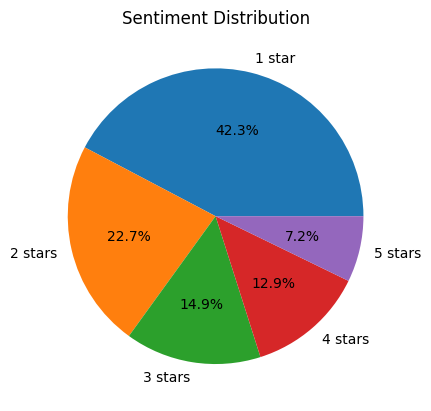

In [11]:
plot_polarity('hugging-npl-town')

In [12]:
hugging_face('cardiffnlp/twitter-roberta-base-emotion', 'hugging-cardiffnlp')

hugging-cardiffnlp
joy         2383
optimism    1023
sadness       99
anger          4
Name: count, dtype: int64


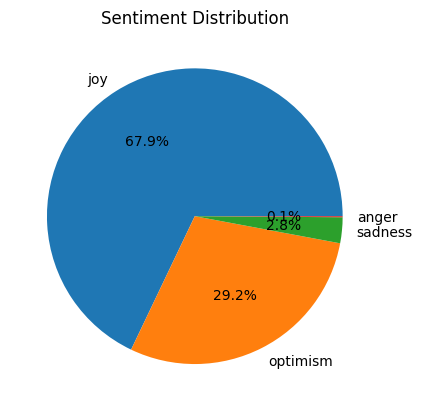

In [13]:
plot_polarity('hugging-cardiffnlp')

In [17]:
hugging_face('cardiffnlp/twitter-xlm-roberta-base', 'hugging-roberta')

Some weights of the model checkpoint at cardiffnlp/twitter-xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-xlm-roberta-base and are newly initialized: ['classifier.den

hugging-roberta
LABEL_1    3420
LABEL_0      89
Name: count, dtype: int64


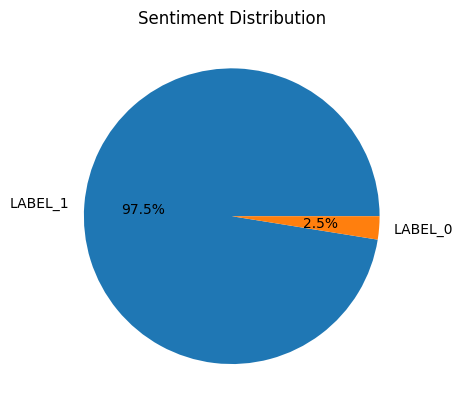

In [18]:
plot_polarity('hugging-roberta')

In [23]:
hugging_face('cardiffnlp/twitter-roberta-base-sentiment', 'hugging-roberta-english')

hugging-roberta-english
LABEL_2    1349
LABEL_0    1287
LABEL_1     873
Name: count, dtype: int64


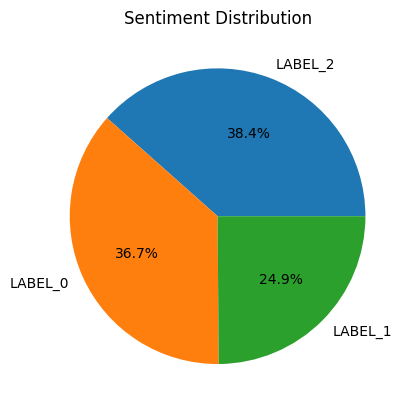

In [24]:
plot_polarity('hugging-roberta-english')

In [25]:
df.head()

,reviews,polarity,hugging-sentiment,hugging-npl-town,hugging-cardiffnlp,vader_polarity,hugging-roberta,hugging-roberta-english
0,worst experience life trying deal customer ser...,negative,NEGATIVE,1 star,joy,negative,LABEL_1,LABEL_0
1,due code sharing cathay pacific downgraded ba ...,negative,NEGATIVE,1 star,joy,negative,LABEL_1,LABEL_0
2,lhr check quick first wing quickly security. f...,positive,NEGATIVE,3 stars,joy,positive,LABEL_1,LABEL_1
3,recommend british airways all. tried call cust...,negative,NEGATIVE,1 star,joy,positive,LABEL_1,LABEL_1
4,absolutely horrible experience. booked ticket ...,negative,NEGATIVE,1 star,joy,negative,LABEL_1,LABEL_0


#### Vader Sentiment

In [14]:
# Define a function to calculate the sentiment polarity of a text using vaderSentiment
def get_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    scores = analyzer.polarity_scores(text)
    if scores['compound'] > 0:
        return 'positive'
    elif scores['compound'] < 0:
        return 'negative'
    else:
        return 'neutral'

# Apply the function to the all_reviews column of the DataFrame to calculate the sentiment polarity of each review
df['vader_polarity'] = df['reviews'].apply(get_sentiment)

# Print the DataFrame to see the results
df.head()

,reviews,polarity,hugging-sentiment,hugging-npl-town,hugging-cardiffnlp,vader_polarity
0,worst experience life trying deal customer ser...,negative,NEGATIVE,1 star,joy,negative
1,due code sharing cathay pacific downgraded ba ...,negative,NEGATIVE,1 star,joy,negative
2,lhr check quick first wing quickly security. f...,positive,NEGATIVE,3 stars,joy,positive
3,recommend british airways all. tried call cust...,negative,NEGATIVE,1 star,joy,positive
4,absolutely horrible experience. booked ticket ...,negative,NEGATIVE,1 star,joy,negative


vader_polarity
positive    2379
negative    1115
neutral       15
Name: count, dtype: int64


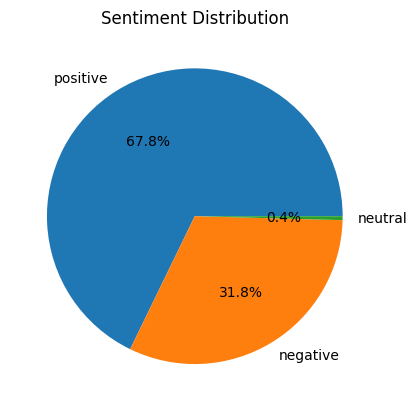

In [15]:
plot_polarity('vader_polarity')